# Importing Libraries

In [8]:
!pip install imbalanced-learn


In [9]:
import requests
import zipfile
import os
from imblearn.over_sampling import SMOTE
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Importing Dataset

In [10]:
url = "https://github.com/mohsley/skin-cancer-detection/raw/refs/heads/main/data.zip"

In [11]:
zip_file_path = "data.zip"
response = requests.get(url)
if response.status_code == 200:
    with open(zip_file_path, "wb") as file:
        file.write(response.content)
    print("ZIP file downloaded successfully.")
else:
    print(f"Failed to download the ZIP file. Status code: {response.status_code}")
    exit()

ZIP file downloaded successfully.


In [12]:
extract_folder = "extracted_data"
os.makedirs(extract_folder, exist_ok=True)
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)
    print("ZIP file extracted successfully.")
except zipfile.BadZipFile:
    print("Error: The downloaded file is not a valid ZIP file.")

ZIP file extracted successfully.


In [13]:
!rm "/content/data.zip"

In [14]:
df = pd.read_csv("/content/extracted_data/data/train-metadata.csv")

<ipython-input-14-f2053e00843a>:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/extracted_data/data/train-metadata.csv")


In [15]:
df

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,...,IL_9520694,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999988
401055,ISIC_9999951,0,IP_5678181,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999820
401056,ISIC_9999960,0,IP_0076153,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,...,IL_9852274,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999416
401057,ISIC_9999964,0,IP_5231513,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000


In [17]:
df.columns

Index(['isic_id', 'target', 'patient_id', 'age_approx', 'sex',
       'anatom_site_general', 'clin_size_long_diam_mm', 'image_type',
       'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
       'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
       'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple',
       'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border',
       'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
       'tbp_lv_z', 'attribution', 'copyright_license', 'lesion_id',
       'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
       'mel_mitotic_index', '

In [18]:
features_to_drop = [
    # maybe drop these, but they don't make accuracy 1 so idk
    'tbp_lv_Lext',
    'tbp_lv_deltaLB',
    'tbp_lv_location_simple',
    'tbp_lv_norm_color',
    'tbp_lv_perimeterMM',
    'tbp_lv_radial_color_std_max',

    # Clinical measurements
    'mel_thick_mm',
    'mel_mitotic_index',

    # Model confidence scores
    'tbp_lv_dnn_lesion_confidence',
    'tbp_lv_nevi_confidence',

    # IDs and metadata (not relevant for prediction)
    'iddx_full',
    'iddx_1',
    'iddx_2',
    'iddx_3',
    'iddx_4',
    'iddx_5',
    'isic_id',
    'patient_id',
    'lesion_id',
    'attribution',
    'copyright_license'
]

In [20]:
df.drop(columns=features_to_drop,inplace=True)

In [22]:
df.head()

,target,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,...,tbp_lv_location,tbp_lv_minorAxisMM,tbp_lv_norm_border,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z
0,0,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,16.261975,26.922447,...,Right Leg - Upper,1.543016,7.091360,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948
1,0,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,25.364740,26.331000,...,Head & Neck,0.821918,2.116402,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500
2,0,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,17.128170,37.970460,...,Torso Back Top Third,1.194905,4.798335,1.743651,1.950777,0.361905,105,123.649700,1472.010000,232.908900
3,0,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,12.164757,21.448144,...,Torso Front Top Half,2.481328,1.975874,1.258541,1.573733,0.209581,130,-141.024780,1442.185791,58.359802
4,0,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,20.057470,26.464900,...,Torso Front Top Half,0.929916,3.658854,2.085409,2.480509,0.313433,20,-72.315640,1488.720000,21.428960


In [24]:
missing_percentages = (df.isnull().sum() / len(df)) * 100
columns_to_keep = missing_percentages[missing_percentages < 50].index
skin_cancer_df= df[columns_to_keep]
skin_cancer_df = skin_cancer_df.fillna(skin_cancer_df.mode().iloc[0])
skin_cancer_df.shape

(401059, 34)

In [26]:
skin_cancer_df.columns

Index(['target', 'age_approx', 'sex', 'anatom_site_general',
       'clin_size_long_diam_mm', 'image_type', 'tbp_tile_type', 'tbp_lv_A',
       'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext',
       'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_areaMM2',
       'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA',
       'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_minorAxisMM',
       'tbp_lv_norm_border', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
       'tbp_lv_z'],
      dtype='object')

In [28]:

skin_cancer_df.head()

,target,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,...,tbp_lv_location,tbp_lv_minorAxisMM,tbp_lv_norm_border,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z
0,0,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,16.261975,26.922447,...,Right Leg - Upper,1.543016,7.091360,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948
1,0,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,25.364740,26.331000,...,Head & Neck,0.821918,2.116402,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500
2,0,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,17.128170,37.970460,...,Torso Back Top Third,1.194905,4.798335,1.743651,1.950777,0.361905,105,123.649700,1472.010000,232.908900
3,0,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,12.164757,21.448144,...,Torso Front Top Half,2.481328,1.975874,1.258541,1.573733,0.209581,130,-141.024780,1442.185791,58.359802
4,0,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,20.057470,26.464900,...,Torso Front Top Half,0.929916,3.658854,2.085409,2.480509,0.313433,20,-72.315640,1488.720000,21.428960


In [30]:
numerical_df = skin_cancer_df.select_dtypes(include=["number"])


In [32]:
numerical_df.head()

,target,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,...,tbp_lv_eccentricity,tbp_lv_minorAxisMM,tbp_lv_norm_border,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z
0,0,60.0,3.04,20.244422,16.261975,26.922447,23.954773,33.684638,28.953117,53.058545,...,0.901302,1.543016,7.091360,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948
1,0,60.0,1.10,31.712570,25.364740,26.331000,24.549290,41.219030,35.299260,39.702910,...,0.639885,0.821918,2.116402,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500
2,0,60.0,3.40,22.575830,17.128170,37.970460,33.485410,44.174920,37.611800,59.265850,...,0.932147,1.194905,4.798335,1.743651,1.950777,0.361905,105,123.649700,1472.010000,232.908900
3,0,65.0,3.22,14.242329,12.164757,21.448144,21.121356,25.746200,24.374023,56.414429,...,0.654458,2.481328,1.975874,1.258541,1.573733,0.209581,130,-141.024780,1442.185791,58.359802
4,0,55.0,2.73,24.725520,20.057470,26.464900,25.710460,36.217980,32.608740,46.946070,...,0.946448,0.929916,3.658854,2.085409,2.480509,0.313433,20,-72.315640,1488.720000,21.428960


In [34]:
numerical_df.shape

(401059, 29)

In [36]:
X = numerical_df.drop('target', axis=1)
y = numerical_df['target']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

In [40]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#SMOTE

In [42]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [44]:
print("Before SMOTE:")
print(y_train.value_counts())
print("After SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

Before SMOTE:
target
0    380632
1       374
Name: count, dtype: int64
After SMOTE:
target
0    380632
1    380632
Name: count, dtype: int64


In [46]:
column_names = [f'feature_{i}' for i in range(X_train_resampled.shape[1])]  # Generate generic column names

# Convert X_train_resampled and y_train_resampled to DataFrame and Series
oversampled_data = pd.concat([
    pd.DataFrame(X_train_resampled, columns=column_names),  # Use generated column names
    pd.Series(y_train_resampled, name='target')             # Assign 'target' name to y
], axis=1)
# Sample 100,000 rows per class and combine
final_data = (oversampled_data.groupby('target')
                            .apply(lambda x: x.sample(n=10000, random_state=42))
                            .reset_index(drop=True)
                            .sample(frac=1, random_state=42))  # Shuffle data

# Split into features and target
X_final = final_data.drop(columns='target')
y_final = final_data['target']

# Verify the distribution
print("Final class distribution:")
print(y_final.value_counts())

Final class distribution:
target
1    10000
0    10000
Name: count, dtype: int64


<ipython-input-46-84e6e2617b4f>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=10000, random_state=42))


# KNN

In [48]:
results = []
roc_data = []

In [50]:
for k in range(2, 11):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_final, y_final)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    # y_proba = knn.predict_proba(X_test)[:, 1]
    y_proba = (knn.predict_proba(X_test)[:, 1] > 0.3)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)  # ROC components
    roc_auc = auc(fpr, tpr)

    results.append((k, accuracy, roc_auc))
    roc_data.append((k, fpr, tpr, roc_auc))  # Store ROC data for later

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not 

In [52]:
results

[(2, 0.9492843963496733, 0.8020995885941268),
 (3, 0.9133795442078492, 0.8457608906963425),
 (4, 0.922854435745275, 0.86764736789563),
 (5, 0.8968234179424525, 0.8682030022645713),
 (6, 0.9064479130304692, 0.8650478397250989),
 (7, 0.8841071161422231, 0.8635149193739065),
 (8, 0.8936817433800429, 0.8638971642943837),
 (9, 0.8757791851593277, 0.8651897038192966),
 (10, 0.8835585697900563, 0.9068136799020612)]

In [54]:

for k, accuracy, roc_auc in results:
    print(f"k={k}, Accuracy={ accuracy:.4f}, AUC={roc_auc:.4f}")

k=2, Accuracy=0.9493, AUC=0.8021
k=3, Accuracy=0.9134, AUC=0.8458
k=4, Accuracy=0.9229, AUC=0.8676
k=5, Accuracy=0.8968, AUC=0.8682
k=6, Accuracy=0.9064, AUC=0.8650
k=7, Accuracy=0.8841, AUC=0.8635
k=8, Accuracy=0.8937, AUC=0.8639
k=9, Accuracy=0.8758, AUC=0.8652
k=10, Accuracy=0.8836, AUC=0.9068


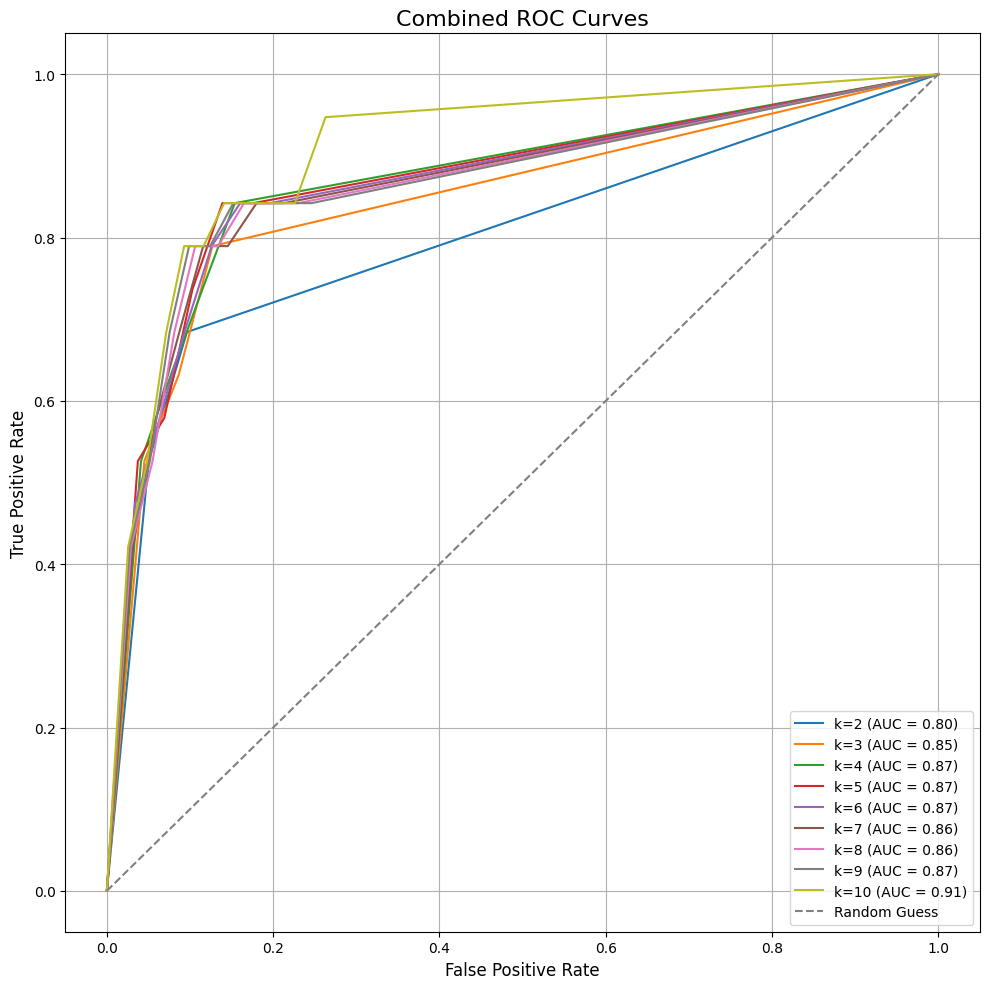

In [56]:
import matplotlib.pyplot as plt

# Plotting all ROC curves in one graph
plt.figure(figsize=(10, 10))

for k, fpr, tpr, roc_auc in roc_data:
    plt.plot(fpr, tpr, label=f"k={k} (AUC = {roc_auc:.2f})")

# Add the random guessing line
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Guess")

# Graph details
plt.title("Combined ROC Curves", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {'n_neighbors': [2,3,4,5,6,7,8,9,10]}

# Initialize KNN and GridSearchCV
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best hyperparameters
best_n_neighbors = grid_search.best_params_['n_neighbors']
print(f"Best n_neighbors: {best_n_neighbors}")

# Train model with best parameters
best_knn = KNeighborsClassifier(n_neighbors=best_n_neighbors)
best_knn.fit(X_train, y_train)
y_pred = best_knn.predict(X_test)

# Confusion matrix for best parameters
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Cancer', 'Cancer'],
            yticklabels=['No Cancer', 'Cancer'])
plt.title(f'Confusion Matrix (Best n_neighbors={best_n_neighbors})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(f"Classification Report for Best n_neighbors={best_n_neighbors}:\n")
print(classification_report(y_test, y_pred))


#----------------END WITH CSV-----------------------





-------------------START WITH IMAGES-----------------

In [ ]:
from google.colab import files
files.upload()


In [ ]:
import os

# Create the .kaggle directory
os.makedirs('/root/.kaggle', exist_ok=True)

# Move kaggle.json to the correct directory
!mv kaggle.json /root/.kaggle/

# Set the correct permissions
!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
%cd '/content/extracted_data/data'

In [ ]:
!kaggle competitions download -c isic-2024-challenge

In [ ]:
!unzip "/content/extracted_data/data/isic-2024-challenge.zip"

In [ ]:
y!rm "/content/extracted_data/data/isic-2024-challenge.zip"

In [ ]:
# import numpy as np
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# from PIL import Image
# from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.decomposition import PCA
# from imblearn.over_sampling import SMOTE
# import os
# from tqdm import tqdm

# df = pd.read_csv("/content/extracted_data/data/train-metadata.csv", low_memory=False)

# class_0 = df[df['target'] == 0]
# class_1 = df[df['target'] == 1]
# class_0_sampled = class_0.sample(n=1000, random_state=42)
# subset_df = pd.concat([class_0_sampled, class_1])

# print(f"Class 0 samples: {len(class_0_sampled)}")
# print(f"Class 1 samples: {len(class_1)}")
# print(f"Total samples: {len(subset_df)}")

# missing_percentages = (subset_df.isnull().sum() / len(subset_df)) * 100
# columns_to_keep = missing_percentages[missing_percentages < 50].index
# skin_cancer_df = subset_df[columns_to_keep]

# features_to_drop = [
#     'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
#     'patient_id', 'lesion_id', 'attribution', 'copyright_license'
# ]

# skin_cancer_df = skin_cancer_df.drop(columns=[col for col in features_to_drop if col in skin_cancer_df.columns])

# numeric_columns = skin_cancer_df.select_dtypes(include=['int64', 'float64']).columns
# categorical_columns = skin_cancer_df.select_dtypes(include=['object', 'category']).columns

# skin_cancer_df[numeric_columns] = skin_cancer_df[numeric_columns].fillna(skin_cancer_df[numeric_columns].median())
# skin_cancer_df[categorical_columns] = skin_cancer_df[categorical_columns].fillna(skin_cancer_df[categorical_columns].mode().iloc[0])

# for col in categorical_columns:
#     if col != 'isic_id':
#         le = LabelEncoder()
#         skin_cancer_df[col] = le.fit_transform(skin_cancer_df[col])

# expected_samples = len(skin_cancer_df)
# image_features = np.zeros((expected_samples, 128 * 128 * 3))
# valid_indices = []

# for idx, isic_id in tqdm(enumerate(skin_cancer_df['isic_id']), total=expected_samples):
#     try:
#         file_path = os.path.join("/content/extracted_data/data/train-image/image", f"{isic_id}.jpg")
#         if os.path.exists(file_path):
#             img = mpimg.imread(file_path)
#             img_resized = np.array(Image.fromarray(img).resize((128, 128)))
#             image_features[idx] = img_resized.reshape(-1)
#             valid_indices.append(idx)
#     except Exception as e:
#         print(f"Error processing {isic_id}: {str(e)}")
#         continue

# if not valid_indices:
#     raise ValueError("No valid images were processed")

# image_features = image_features[valid_indices]
# image_features_scaled = image_features / 255.0

# n_components = 100
# pca = PCA(n_components=n_components, random_state=42)
# image_features_pca = pca.fit_transform(image_features_scaled)

# pca_columns = [f'pca_{i}' for i in range(n_components)]
# image_df = pd.DataFrame(image_features_pca, columns=pca_columns)
# explained_variance = np.cumsum(pca.explained_variance_ratio_)
# print(f"\nVariance explained by {n_components} components: {explained_variance[-1]}")

# skin_cancer_df = skin_cancer_df.iloc[valid_indices]
# X = pd.concat([
#     skin_cancer_df.drop(['isic_id', 'target'], axis=1).reset_index(drop=True),
#     image_df
# ], axis=1)
# y = skin_cancer_df['target'].reset_index(drop=True)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import os
from tqdm import tqdm

df = pd.read_csv("/content/extracted_data/data/train-metadata.csv", low_memory=False)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(df.head)
benign = df[df['target'] == 0]
malignant  = df[df['target'] == 1]

benign_sampled = benign.sample(n=3000, random_state=42)
subset_df = pd.concat([benign_sampled, malignant ])

print(f"Class 0 samples: {len(benign_sampled)}")
print(f"Class 1 samples: {len(malignant )}")
print(f"Total samples: {len(subset_df)}")

missing_percentages = (subset_df.isnull().sum() / len(subset_df)) * 100
columns_to_keep = missing_percentages[missing_percentages < 50].index
skin_cancer_df = subset_df[columns_to_keep]

features_to_drop = [
    'iddx_full',
    'iddx_1',
    'iddx_2',
    'iddx_3',
    'iddx_4',
    'iddx_5',
    'patient_id',
    'lesion_id',
    'attribution',
    'copyright_license'
]

# We do this because depending on the seed and shuffle, the columns that get dropped will be different!
for col in features_to_drop:
    if col in skin_cancer_df.columns:
        print(f"Dropping column: {col}")
        skin_cancer_df = skin_cancer_df.drop(columns=[col])

numeric_columns = skin_cancer_df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = skin_cancer_df.select_dtypes(include=['object', 'category']).columns

skin_cancer_df[numeric_columns] = skin_cancer_df[numeric_columns].fillna(
    skin_cancer_df[numeric_columns].median())
skin_cancer_df[categorical_columns] = skin_cancer_df[categorical_columns].fillna(
    skin_cancer_df[categorical_columns].mode().iloc[0])

for col in categorical_columns:
    if col != 'isic_id':
        le = LabelEncoder()
        skin_cancer_df[col] = le.fit_transform(skin_cancer_df[col])

expected_samples = len(skin_cancer_df)
image_features = np.zeros((expected_samples, 128 * 128 * 3))
valid_indices = []

for idx, isic_id in tqdm(enumerate(skin_cancer_df['isic_id']), total=expected_samples):
    try:
        file_path = os.path.join(("/content/extracted_data/data/train-image/image", f"{isic_id}.jpg")
        if os.path.exists(file_path):
            img = mpimg.imread(file_path)
            img_resized = np.array(Image.fromarray(img).resize((128, 128)))
            image_features[idx] = img_resized.reshape(-1)
            valid_indices.append(idx)
    except Exception as e:
        print(f"Error processing {isic_id}: {str(e)}")
        continue

if not valid_indices:
    raise ValueError("No valid images were processed")

image_features = image_features[valid_indices]

image_features_scaled = image_features / 255.0
n_components = 150
pca = PCA(n_components=n_components, random_state=42)
image_features_pca = pca.fit_transform(image_features_scaled)

pca_columns = [f'pca_{i}' for i in range(n_components)]
image_df = pd.DataFrame(image_features_pca, columns=pca_columns)

explained_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"\nVariance explained by {n_components} components: {explained_variance[-1]}")

X = pd.concat([
    skin_cancer_df.drop(['isic_id', 'target'], axis=1).reset_index(drop=True),
    image_df
], axis=1)
y = skin_cancer_df['target'].reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
train_score = {}
test_score = {}
n_neighbors = np.arange(2, 10, 1)
for neighbor in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=neighbor)
    knn.fit(X_train, y_train)
    train_score[neighbor]=knn.score(X_train, y_train)
    test_score[neighbor]=knn.score(X_test, y_test)

In [ ]:
plt.plot(n_neighbors, train_score.values(), label="Train Accuracy")
plt.plot(n_neighbors, test_score.values(), label="Test Accuracy")
plt.xlabel("Number Of Neighbors")
plt.ylabel("Accuracy")
plt.title("KNN: Varying number of Neighbors")
plt.legend()
plt.xlim(0, 33)
plt.ylim(0.60, 0.90)
plt.grid()
plt.show()

In [ ]:
results = []
roc_data = []
for k in range(2, 11):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    y_proba = knn.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)  # ROC components
    roc_auc = auc(fpr, tpr)

    results.append((k, accuracy, roc_auc))
    roc_data.append((k, fpr, tpr, roc_auc))

In [ ]:
for k, accuracy, roc_auc in results:
    print(f"k={k}, AUC={roc_auc:.4f}, Accuracy={accuracy:.4f}")

In [ ]:
import matplotlib.pyplot as plt

# Plotting all ROC curves in one graph
plt.figure(figsize=(10, 10))

for k, fpr, tpr, roc_auc in roc_data:
    plt.plot(fpr, tpr, label=f"k={k} (AUC = {roc_auc:.2f})")

# Add the random guessing line
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Guess")

# Graph details
plt.title("Combined ROC Curves", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {'n_neighbors': [2,3,4,5,6,7,8,9,10]}

# Initialize KNN and GridSearchCV
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best hyperparameters
best_n_neighbors = grid_search.best_params_['n_neighbors']
print(f"Best n_neighbors: {best_n_neighbors}")

# Train model with best parameters
best_knn = KNeighborsClassifier(n_neighbors=best_n_neighbors)
best_knn.fit(X_train, y_train)
y_pred = best_knn.predict(X_test)

# Confusion matrix for best parameters
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Cancer', 'Cancer'],
            yticklabels=['No Cancer', 'Cancer'])
plt.title(f'Confusion Matrix (Best n_neighbors={best_n_neighbors})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(f"Classification Report for Best n_neighbors={best_n_neighbors}:\n")
print(classification_report(y_test, y_pred))
